# Vertical multi-omics integration - finding associations between expression and accessibility

<!-- In this notebook we will perform exploratory analysis and joint dimensionality reduction on matched scRNA-seq and scATAC-seq data of developing brain cortex from [Trevino et al.2021](https://www.cell.com/cell/fulltext/S0092-8674(21)00942-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867421009429%3Fshowall%3Dtrue), focusing on differentiation of excitatory glutamatergic neurons.

What we will cover:

1. Construction of objects for multi-modal data handling using [muon]()
2. Joint exploratory data analysis
3. Dimensionality reduction with multi-view models ("vertical" integration) using [Multi-Omics Factor Analysis]() and [Weighted Nearest-Neighbor graphs]()
4. Basics of feature-wise analysis

What we _won't_ cover:

1. Methods for aggregation of expression and accessibility profiles from single-cells for inference of regulatory links (see [SEAcells]()) -->


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy

import muon as mu
import anndata

import pyranges

## Plotting utils
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

/home/jovyan/my-conda-envs/sc2022-multiomics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## Set plotting parameters for scanpy
sc.set_figure_params(figsize=[9,9], color_map = 'viridis_r')

<!-- <div class="alert alert-block alert-info"> 
    
    <b>New to python?</b> Don't panic! Use [help] to 
    
</div>
 -->

## Load multi-omic data

This is the dataset stored in `MuData` format and processed in the [`joint embedding notebook`]().

In [1]:
## Put the path to the data here
# # from AWS instance
# data_dir = "/data/multiomics/gr2_matched_vertical"
data_dir = "/home/jovyan/mount/gdrive/sc-multiomics-course-2022/gr2_matched_vertical/"

In [6]:
mdata = mu.read("{d}/vertical_clean_embeddings.h5mu".format(d=data_dir))

## Quantify the agreement between gene accessibility and gene expression

- On average, are gene expression and accessibility of gene bodies and promoters related?
- Does this vary by cluster?
- Are proximal intergenic regions are more predictive of gene expression that gene accessibility? 

## Matching genes and peaks 

We need to a set of pairs of genes and peaks (or other features extracted from ATAC) we will test for association between gene expression and chromatin accessibility.

We could be greedy and try to test all the possible combinations of genes and peaks, but this would likely be prohibitively computationally expensive (with > 30K genes and > 400k peaks!), not to mention the multiple testing burden we would have. In addition, we know that long range interactions on the genome are possible, but they are not very common, so it doesn't make too much sense to test for associations between genes and chromatin regions that are extremely far apart e.g. on different chromosomes. Instead, we can focus on peaks that are proximal or overlapping a genes.


To find peaks that are overlapping or proximal to a certain gene, we can use functionality in the [pyranges]() python package, here wrapped in a helper function `peak2gene`.

In [379]:
def _pyranges_from_strings(pos_list):
    """
    Function to create pyranges for a `pd.Series` of strings
    (borrowed from SEAcells https://github.com/dpeerlab/SEACells)
    """
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)
                      ).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)
                    ).str.split('-').str.get(1)

    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    return gr


def _pyranges_to_strings(peaks):
    """
    Function to convert pyranges to `pd.Series` of strings of format 'chr:start-end'
    (borrowed from SEAcells https://github.com/dpeerlab/SEACells)
    """
    # Chromosome and positions
    chr = peaks.Chromosome.astype(str).values
    start = peaks.Start.astype(str).values
    end = peaks.End.astype(str).values

    # Create ranges
    gr = chr + ':' + start + '-' + end

    return gr

def peaks2gene(gene_id, 
               peaks_var, 
               all_genes_df = genes_df,
               win_size = 0,
               chr_col_name = 'seqnames'               
              ):
        '''
        Find peaks within window of gene
        
        Params:
        -------
        - gene_id: ensemblID of gene of interest
        - peaks_var: var dataframe for all peaks
        - all_genes_df: dataframe of genomic ranges for all genes (extracted via pyensembl or otherwise)
        - win_size: size of window around gene to extend
        - chr_col_name: column in peak var storing chromosome information
        
        Returns: var_names of overlapping peaks
        '''
        if 'peak_string' not in peaks_var.columns:
            var['peak_string'] = var[chr_col_name].astype('str') + ':' + var['start'].astype('str') + '-' + var['end'].astype('str')            
        
        if not gene_id.startswith("ENS"):
            raise ValueError("The gene_id should be an ensemblID")
        
        ## Convert peaks to pyranges
        peaks_gr = pyranges.PyRanges(chromosomes=var[chr_col_name], starts=var['start'], ends=var['end'])
        
        ## Convert genes to pyranges
        gene_df = all_genes_df[all_genes_df['GeneID'] == gene_id]
        gene_gr = pyranges.PyRanges(chromosomes=gene_df["Chromosome"], starts=gene_df['Start'], ends=gene_df['End'])
        
        ## Extend gene range by window size
        win_gene_gr = gene_gr.extend(win_size)
        
        ## Find overlapping peaks
        gene_peaks = peaks_gr.overlap(win_gene_gr)
        if len(gene_peaks) > 0:
            gene_peak_strings = _pyranges_to_strings(gene_peaks)
            return(var.index[var['peak_string'].isin(gene_peak_strings)])
        else:
            return([])

Because testing on all the genes would be computationally intensive and take a long time, here we will focus on finding association between gene expression and chromatin accessibility on a set of known marker genes of different stages of GluN differentiation.

In [2]:
marker_genes = ['EOMES', 'PPP1R17', 'PENK', 'NEUROG1', 'NEUROG2',
    'NEUROD2', 'TBR1', 'BCL11B', 'SATB2', 'SLC17A7']

In [425]:
marker_genes_df = genes_df[genes_df['GeneName'].isin(marker_genes)]

i=0
connectivities = mdata.obsp["mofa_connectivities"] ## Which KNN graph to use for smoothing

## Find peaks within 10kb
gene_peaks = peaks2gene(marker_genes_df.GeneID.iloc[i], mdata['atac'].var, win_size=10000)

## Subset adata to peaks and gene of interest
sdata_atac = mdata['atac'][:,gene_peaks].copy()
sdata_rna = mdata['rna'][:,marker_genes_df.GeneName.iloc[i]].copy()

## Run KNN smoothing on accessibility profiles
X_acc = sdata_atac.X.copy()
X_acc_smooth = knn_smoothing(X_acc, connectivities)

X_gex = sdata_rna.X.copy()
X_gex_smooth = knn_smoothing(X_gex, connectivities)

## Smoothing gene expression and accessibility profiles

For feature-wise analysis, data is frequently denoised using KNN imputation, where we substitute the profile of a cell with the average profile of the cell and its k nearest neighbors.

In [415]:
def knn_smoothing(X_features, connectivities):
    '''
    Transform cell profile to average profile of neighbors
    
    params:
    -------
    - X_features: sparse matrix of dimensions cells x features to denoise
    - connectivities: connectivity matrix for KNN graph of dimensions cells x cells
    '''
    X_imputed = (
        scipy.sparse.csr_matrix.dot(connectivities.T, X_features)
        .astype(np.float32)
    )
    if scipy.sparse.issparse(X_imputed):
        X_imputed = X_imputed.A
    X_imputed = X_imputed / X_features.sum(1).reshape(X_features.shape[0], 1)
    X_imputed = np.array(X_imputed)
    X_imputed[np.isnan(X_imputed)] = 0
    X_imputed[np.isinf(X_imputed)] = 0
    return(X_imputed)

# X_gex = mdata['rna'].X.copy()
# mdata['rna'].layers['knn_smoothed_logcounts'] = knn_smoothing(X_gex, mdata.obsp["mofa_connectivities"])

# X_gene_activity = mdata['atac'].obsm['gene_activity'].copy()
# mdata['atac'].obsm['knn_smoothed_gene_activity'] = knn_smoothing(X_gene_activity, mdata.obsp["mofa_connectivities"])

Then we need the genomic locations of genes. In this case we have saved this info in `mdata['rna'].var`, or you can access genomic ranges using pyensembl.

In [250]:
from pyensembl import EnsemblRelease
def ens_genes2df(genes):
    '''
    Convert pyemsembl genes to feature 
    dataframe readable by muon
    '''
    genes_df = pd.DataFrame()
    genes_df['Chromosome'] = ["chr" + x.contig for x in genes]
    genes_df['Start'] = [x.start for x in genes]
    genes_df['End'] = [x.end for x in genes]
    genes_df['GeneName'] = [x.gene_name for x in genes]
    genes_df['GeneID'] = [x.gene_id for x in genes]
    return(genes_df)

data = EnsemblRelease(77)
gene_names = data.genes()
genes_df = ens_genes2df(gene_names)

In [242]:
# def get_gene_gex_and_activity(mdata,g):
#     X_gene_activity = mdata['atac'].obsm['knn_smoothed_gene_activity']
#     g_ix = np.where(mdata['atac'].uns['gene_activity_var']["GeneName"] == g)[0][0]
#     mdata.obs[f'gene_accessibility'] = X_gene_activity[:,g_ix].copy()
#     mdata.obs[f'gene_expression'] = mdata['rna'][:,g].layers['knn_smoothed_logcounts'].toarray().ravel()

# get_gene_gex_and_activity(mdata, 'CD8B')
# mdata.obs[['gene_expression', 'gene_accessibility']].corr()

# sc.pl.scatter(mdata, "gene_expression", 'gene_accessibility', size=40)

To find peaks that are overlapping or proximal to genes, we can use functionality in the [pyranges]() python package, here wrapped in a helper function.

In [379]:
def _pyranges_from_strings(pos_list):
    """
    Function to create pyranges for a `pd.Series` of strings
    (borrowed from SEAcells https://github.com/dpeerlab/SEACells)
    """
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)
                      ).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)
                    ).str.split('-').str.get(1)

    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    return gr


def _pyranges_to_strings(peaks):
    """
    Function to convert pyranges to `pd.Series` of strings of format 'chr:start-end'
    (borrowed from SEAcells https://github.com/dpeerlab/SEACells)
    """
    # Chromosome and positions
    chr = peaks.Chromosome.astype(str).values
    start = peaks.Start.astype(str).values
    end = peaks.End.astype(str).values

    # Create ranges
    gr = chr + ':' + start + '-' + end

    return gr

def peaks2gene(gene_id, 
               peaks_var, 
               all_genes_df = genes_df,
               win_size = 0,
               chr_col_name = 'seqnames'               
              ):
        '''
        Find peaks within window of gene
        
        Params:
        -------
        - gene_id: ensemblID of gene of interest
        - peaks_var: var dataframe for all peaks
        - all_genes_df: dataframe of genomic ranges for all genes (extracted via pyensembl or otherwise)
        - win_size: size of window around gene to extend
        - chr_col_name: column in peak var storing chromosome information
        
        Returns: var_names of overlapping peaks
        '''
        if 'peak_string' not in peaks_var.columns:
            var['peak_string'] = var[chr_col_name].astype('str') + ':' + var['start'].astype('str') + '-' + var['end'].astype('str')            
        
        if not gene_id.startswith("ENS"):
            raise ValueError("The gene_id should be an ensemblID")
        
        ## Convert peaks to pyranges
        peaks_gr = pyranges.PyRanges(chromosomes=var[chr_col_name], starts=var['start'], ends=var['end'])
        
        ## Convert genes to pyranges
        gene_df = all_genes_df[all_genes_df['GeneID'] == gene_id]
        gene_gr = pyranges.PyRanges(chromosomes=gene_df["Chromosome"], starts=gene_df['Start'], ends=gene_df['End'])
        
        ## Extend gene range by window size
        win_gene_gr = gene_gr.extend(win_size)
        
        ## Find overlapping peaks
        gene_peaks = peaks_gr.overlap(win_gene_gr)
        if len(gene_peaks) > 0:
            gene_peak_strings = _pyranges_to_strings(gene_peaks)
            return(var.index[var['peak_string'].isin(gene_peak_strings)])
        else:
            return([])

Because testing on all the genes would be computationally intensive, we can test this analysis first on a set of known marker genes of different stages of GluN differentiation.

In [425]:
marker_genes = ['EOMES', 'PPP1R17', 'PENK', 'NEUROG1', 'NEUROG2',
    'NEUROD2', 'TBR1', 'BCL11B', 'SATB2', 'SLC17A7']

marker_genes_df = genes_df[genes_df['GeneName'].isin(marker_genes)]

i=0
connectivities = mdata.obsp["mofa_connectivities"] ## Which KNN graph to use for smoothing

## Find peaks within 10kb
gene_peaks = peaks2gene(marker_genes_df.GeneID.iloc[i], mdata['atac'].var, win_size=10000)

## Subset adata to peaks and gene of interest
sdata_atac = mdata['atac'][:,gene_peaks].copy()
sdata_rna = mdata['rna'][:,marker_genes_df.GeneName.iloc[i]].copy()

## Run KNN smoothing on accessibility profiles
X_acc = sdata_atac.X.copy()
X_acc_smooth = knn_smoothing(X_acc, connectivities)

X_gex = sdata_rna.X.copy()
X_gex_smooth = knn_smoothing(X_gex, connectivities)

In [434]:
# Compute correlations
from scipy.stats import rankdata
from sklearn.metrics import pairwise_distances

## Compute correlations to true peaks
cors = 1 - np.ravel(pairwise_distances(np.apply_along_axis(rankdata, 1, X_acc_smooth.T),
                                       rankdata(X_gex_smooth.T).reshape(
                                           1, -1),
                                       metric='correlation'))
cors = pd.Series(cors, index = sdata_atac.var_names)

In [ ]:
# Random background
df = pd.DataFrame(1.0, index=cors.index, columns=['cor', 'pval'])
df['cor'] = cors
for p in df.index:
    try:
        # Try random sampling without replacement
        rand_peaks = np.random.choice(atac_meta_ad.var_names[(atac_meta_ad.var['GC_bin'] == atac_meta_ad.var['GC_bin'][p]) &
                                                             (atac_meta_ad.var['counts_bin'] == atac_meta_ad.var['counts_bin'][
                                                                 p])], n_rand_sample, False)
    except:
        rand_peaks = np.random.choice(atac_meta_ad.var_names[(atac_meta_ad.var['GC_bin'] == atac_meta_ad.var['GC_bin'][p]) &
                                                             (atac_meta_ad.var['counts_bin'] == atac_meta_ad.var['counts_bin'][
                                                                 p])], n_rand_sample, True)

    if type(atac_exprs) is sc.AnnData:
        X = pd.DataFrame(atac_exprs[:, rand_peaks].X.todense().T)
    else:
        X = atac_exprs.loc[:, rand_peaks].T

    rand_cors = 1 - np.ravel(pairwise_distances(np.apply_along_axis(rankdata, 1, X.values),
                                                rankdata(rna_exprs[gene].T.values).reshape(
                                                    1, -1),
                                                metric='correlation'))

    m = np.mean(rand_cors)
    v = np.std(rand_cors)

    from scipy.stats import norm
    df.loc[p, 'pval'] = 1 - norm.cdf(cors[p], m, v)

---

# old

## Step 2: Selecting features for chromatin-expression associations

Now that you have a common embedding and hopefully a common pseudotime axis, we need to select the features that we will use to associate gene expression to chromatin accessibility. We could be greedy and try to test all the possible combinations of genes and peaks, but this would likely be prohibitively computationally expensive (with > 30K genes and > 400k peaks!), not to mention the multiple testing burden we would have. In addition, we know that long range interactions on the genome are possible, but they are not very common, so it doesn't make too much sense to test for associations between genes and chromatin regions that are extremely far apart e.g. on different chromosomes. 

**Feature selection for gene expression:** select a subset of interesting genes that seem to have a dynamic behaviour in the differentiation trajectory. You could select these with standard strategies for variable gene selection (in [R](https://bioconductor.org/books/release/OSCA/feature-selection.html), in [python](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html)), or you could correlate the log-normalized gene expression to the value of pseudotime, to select genes that increase or decrease in expression during differentiation. 

For better approaches to find variable genes in pseudotime, see [tradeSeq](https://bioconductor.org/packages/release/bioc/html/tradeSeq.html) or [cellrank](https://cellrank.readthedocs.io/en/stable/auto_examples/other/plot_model.html#sphx-glr-auto-examples-other-plot-model-py).

**Feature selection for chromatin accessibility:** you'll need to decide _what type of features_ and _which features_ to use at the chromatin level:

- what type of feature: you could use all the peak identified by peak calling, or aggregate counts in peaks that contain the same transcription factor binding motifs (e.g. using [ChromVAR](https://github.com/GreenleafLab/chromVAR)), aggregate counts over peaks in larger genomic windows, collapse counts from co-accessible peaks identified using [Cicero](https://cole-trapnell-lab.github.io/cicero-release/docs_m3/#installing-cicero), any other ideas...?
- which chromatin features should be tested against which genes? Especially if you pick features defined by genomic positions, it's best to subset the possible gene-region pairs to regions within a certain range of the gene. A window of 100k base pairs is often used. See below for an example implementation (in R) to associate genes to peaks in their proximity, using the functionality from [`GenomicRanges`](https://bioconductor.org/packages/release/bioc/vignettes/GenomicRanges/inst/doc/GenomicRangesIntroduction.html).


In [16]:
%%R
library(tidyr)
## Helper functions 

## String - GRanges conversion
## Borrowed from Signac functions 
## https://satijalab.org/signac/reference/GRangesToString.html
StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}

# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing genomic locations of peaks
# @param features_gr GenomicRanges object containing genomic locations of features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix matching peaks to proximal features (peaks in rows, features in columns)
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  adj_mat <- Matrix::Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
}

R[write to console]: 
Attaching package: ‘tidyr’


R[write to console]: The following object is masked from ‘package:S4Vectors’:

    expand




Remember that the peak positions are stored in `mdata.mod["atac"].var` while you can extract genomic locations of the gene bodies using the R package [`ensembldb`](https://bioconductor.org/packages/release/bioc/vignettes/ensembldb/inst/doc/ensembldb.html#4_Retrieving_sequences_for_genetranscriptexon_models)

In [ ]:
## ...
## Your feature selection / peak-gene pairing code goes here
## ...

#### Select variable genes in pseudotime

In [97]:
from scipy.stats import pearsonr
X_logcounts = mdata['rna'].X.T
keep_genes = np.where(mdata['rna'].var["highly_variable"])[0] 
X_logcounts = X_logcounts[keep_genes,:] 
mdata['rna'].var["dpt_corr_r2"] = np.nan
mdata['rna'].var["dpt_corr_r2"] = np.nan
for i in range(X_logcounts.shape[0]):
    r2,pval = pearsonr(mdata.obs.loc[mdata["rna"].obs_names,"dpt_pseudotime_MOFA"],X_logcounts[i,:].toarray().flatten())
    mdata['rna'].var.loc[mdata["rna"].var_names[keep_genes[i]],"dpt_corr_r2"] = r2
    mdata['rna'].var.loc[mdata["rna"].var_names[keep_genes[i]],"dpt_corr_pval"] = pval

## Adjust for multiple testing
from statsmodels.stats import multitest
_,adj_pvals,_,_ = multitest.multipletests(mdata['rna'].var["dpt_corr_pval"].dropna(), method="fdr_bh")

mdata['rna'].var["dpt_corr_adj_pval"] = np.nan
mdata['rna'].var.loc[~mdata['rna'].var["dpt_corr_pval"].isna(), "dpt_corr_adj_pval"] = adj_pvals

mdata['rna'].var["dpt_corr_neg_log10_pval"] = -np.log10(mdata['rna'].var["dpt_corr_adj_pval"])

In [98]:
## We define as associated to pseudotime genes with absolute correlation > 0.2
mdata['rna'].var["dpt_associated_gene"] = abs(mdata['rna'].var["dpt_corr_r2"]) > 0.2

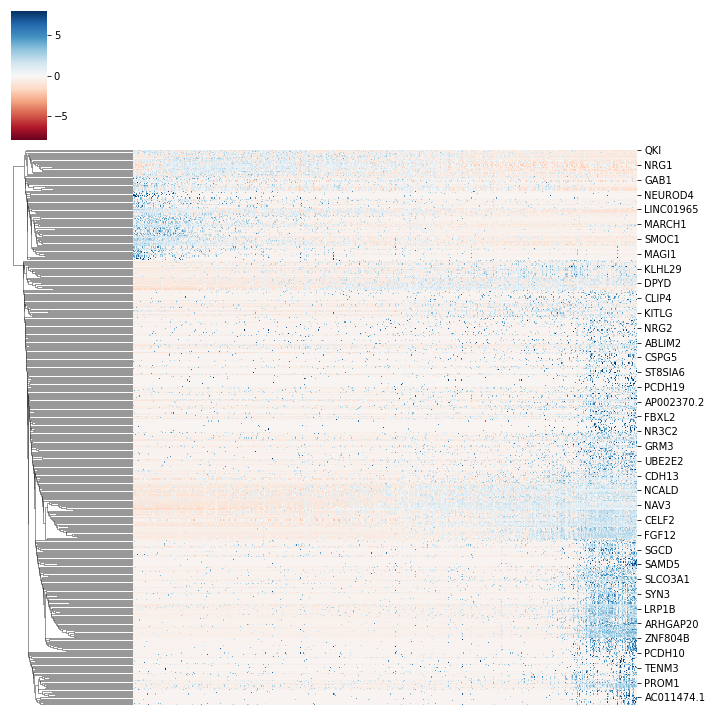

In [99]:
## Extract expression matrix with genes ordered by pseudotime
dpt_order_gex_matrix = mdata["rna"][mdata.obs.loc[mdata["rna"].obs_names,"dpt_pseudotime_MOFA"].argsort(),mdata['rna'].var["dpt_associated_gene"]].X.toarray()
dpt_order_gex_matrix = sc.pp.scale(dpt_order_gex_matrix)
dpt_order_gex_matrix = pd.DataFrame(dpt_order_gex_matrix.T)
dpt_order_gex_matrix.index = mdata['rna'].var_names[mdata['rna'].var["dpt_associated_gene"]]

import seaborn as sns
plt.rcParams["figure.figsize"] = [10,10]
sns.clustermap(dpt_order_gex_matrix, xticklabels=False, col_cluster=False, cmap="RdBu",
              vmin=-8, vmax=8)

In [103]:
## Do we find the known marker genes?
[x in mdata['rna'].var_names[mdata['rna'].var["dpt_associated_gene"]] for x in marker_genes["nIPC"] + marker_genes["GluN"]]

[True, True, True, False, False, False, False, False, True, False]

---

## Step 3: Aggregate expression/accessibility profiles from multiple cells

This step is optional, but highly recommended! In principle, we could test for correlations between gene expression and chromatin accessibility in single-cells (even the the _unmatched assays_ group can impute an accessibility profile for scRNA cells (and viceversa an expression profile for scATAC cells) taking the average profile of nearest neighbors.

However, it's worth thinking about **aggregating profiles from multiple cells**, using clustering or the KNN graph on the common embedding. This is helpful to deal with the high sparsity of the scATAC profiles, to prioritize the most robust associations and to reduce the computational burden of testing for associations. Think of how you could use a common KNN graph for this purpose: You could sample _n_ cells and create pseudobulk profiles from the K-nearest neighbors of those cells (selecting neighbourhoods where there is a sufficient number of cells from both assays in the case of unmatched data). More robust algorithms to sample neighbourhoods on the KNN graph are implemented in [miloR](https://github.com/MarioniLab/miloR) or [MetaCell](https://github.com/tanaylab/metacell). Alternatively, overclustering with the Louvain or Leiden algorithm can be used.


---

## Step 4: Associating gene expression to accessibility

To test for correlation between gene expression and chromatin accessibility, a common approach is to compute a gene-peak correlation coefficient (Spearman ⍴ or Pearson R2) by correlating normalized scATAC-seq peak peak counts with the corresponding gene’s expression across all ATAC-RNA paired cells. Then the observed coefficient for each gene-peak pair is compared to the coefficients obtained matching the gene to _n_ "background peaks" with matching total accessibility and GC content to the tested one, accounting for technical biases between cells that are caused by PCR amplification or variable Tn5 tagmentation conditions. This results in a null peak-gene correlation distribution that is independent of peak-gene proximity, that can be used for significance testing (for reference see [Ma et al. 2020](https://www.cell.com/cell/fulltext/S0092-8674(20)31253-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867420312538%3Fshowall%3Dtrue), [Kartha et al. 2021](https://www.biorxiv.org/content/10.1101/2021.07.28.453784v1.full)).

The chromVAR package implements simple functions to identify the background peaks:
```R
## In R
library(chromVAR)
library(BSgenome.Hsapiens.UCSC.hg38) ## your reference genome

atac_sce <- readRDS("./processed_data/Multiome_ATAC_ext_trajectory_SCE.RDS")
atac_chromvar_sce <- addGCBias(atac_sce, genome=BSgenome.Hsapiens.UCSC.hg38)
bg <- getBackgroundPeaks(atac_chromvar_sce, niterations = 50) ## This can take a while
```

The ArchR package also provides a [`Peak2GeneLinkage`](https://www.archrproject.com/bookdown/peak2genelinkage-with-archr.html) function to perform a similar mapping (however this only works if you follow their RNA-ATAC integration pipeline from start to finish).

So far out of the ArchR pipeline, there is no well-packaged software tool to test these associations between peaks and genes in single-cell multiomics data. Below we show an example implementation in R, adapting code from [the Buenrostro lab](https://github.com/buenrostrolab/stimATAC_analyses_code).

**Test on a few genes first!** You don't want your code to run for 10 minutes to find out it didn't work at all.


In [42]:
%%R
library(dplyr)

## Function to correlate peak expression to gene accessibility
#
# @param rna_sce a SingleCellExperiment object for RNA modality
# @param atac_sce a SingleCellExperiment object for ATAC modality
# @param pairnames a matrix of dimensions 2 * no. of pairs to test, where h 
# 
# @return updated pairnames matrix with an additional column containing 
# the spearman correlation coefficient for the pair
# 
run_p2gene_cor <- function(rna_sce, atac_sce, pairnames){
  pairnames <- as.data.frame(pairnames)
  uniq_peaks <- unique(pairnames[,1])
  uniq_genes <- unique(pairnames[,2])
  
  A = assay(atac_sce) # ATAC matrix
  R = assay(rna_sce) # RNA matrix
  
  all_peaks <- GRangesToString(rowRanges(atac_sce), sep = c("-", "-"))
  uniq_peaks_ixs <- which(all_peaks %in% uniq_peaks)
  uniq_genes_ixs <- which(rownames(R) %in% uniq_genes)
  
  M1 <- as.matrix(Matrix::t(A[uniq_peaks_ixs,,drop=FALSE])) 
  M2 <- as.matrix(Matrix::t(R[uniq_genes_ixs,,drop=FALSE])) 
  
  cormat <- cor(x = M1, y = M2, method = "spearman")
  rownames(cormat) <- all_peaks[uniq_peaks_ixs]
  colnames(cormat) <- rownames(R)[uniq_genes_ixs]
  cors <- sapply(1:nrow(pairnames), function(i) cormat[pairnames[i,1], pairnames[i,2]])
  pairnames <- cbind(pairnames, cors)
  colnames(pairnames) <- c("peak", "gene", "cor")
  return(pairnames)
}

In [340]:
%%R -i agg_atac_adata
rowRanges(agg_atac_adata) <- StringToGRanges(rownames(agg_atac_adata))
rownames(agg_atac_adata) <- peak_ids
agg_atac_adata

class: SingleCellExperiment 
dim: 444692 516 
metadata(0):
assays(1): X
rownames(444692): chr1-180451-180951 chr1-181254-181754 ...
  chr22-50783378-50783878 chr22-50807894-50808394
rowData names(0):
colnames(516): 0 1 ... 514 515
colData names(0):
reducedDimNames(0):
altExpNames(0):


In [314]:
%%R -i agg_rna_adata
agg_rna_adata

class: SingleCellExperiment 
dim: 26572 516 
metadata(0):
assays(1): X
rownames(26572): ENSG00000238009 ENSG00000241860 ... ENSG00000198695
  ENSG00000198727
rowData names(0):
colnames(516): 0 1 ... 514 515
colData names(0):
reducedDimNames(0):
altExpNames(0):


In [58]:
%%R -i pairnames
pairnames <- pairnames[pairnames[,'gene'] %in% rownames(agg_rna_adata),]
pairnames <- pairnames[pairnames[,'peak'] %in% rownames(agg_atac_adata),]
head(pairnames)

                  peak            gene
1 chr1-4637203-4637703 ENSG00000196581
2 chr1-4650315-4650815 ENSG00000196581
3 chr1-4652491-4652991 ENSG00000196581
4 chr1-4653794-4654294 ENSG00000196581
5 chr1-4654342-4654842 ENSG00000196581
6 chr1-4655017-4655517 ENSG00000196581


In [49]:
%%R
# saveRDS(agg_rna_adata, paste0(output_dir, "aggregated_RNA_SCE.RDS"))
# saveRDS(agg_atac_adata, paste0(output_dir, "aggregated_ATAC_SCE.RDS"))

NULL


In [14]:
%%R
agg_rna_adata <- readRDS(paste0(output_dir, "aggregated_RNA_SCE.RDS"))
agg_atac_adata <- readRDS(paste0(output_dir, "aggregated_ATAC_SCE.RDS"))

In [100]:
%%R 
## Compute background peaks
library(chromVAR)
library(BSgenome.Hsapiens.UCSC.hg38)

atac_sce <- readRDS("/home/jovyan/mount/gdrive/sc-multiomics-course-2021/processed_data/input/gr2_matched_vertical/Multiome_ATAC_clean_SCE.RDS")
atac_chromvar_sce <- addGCBias(atac_sce, genome=BSgenome.Hsapiens.UCSC.hg38)
atac_chromvar_sce <- atac_chromvar_sce[rowSums(assay(atac_chromvar_sce)) > 0,]
rownames(atac_chromvar_sce) <- GRangesToString(rowRanges(atac_chromvar_sce))
atac_chromvar_sce <- atac_chromvar_sce[rownames(atac_chromvar_sce) %in% rownames(agg_atac_adata),]
bg <- getBackgroundPeaks(atac_chromvar_sce, niterations = 50)
rownames(bg) <- GRangesToString(rowRanges(atac_chromvar_sce))
# bg <- bg[rownames(bg) %in% rownames(agg_atac_adata),]

In [59]:
%%R
## Compute correlation of true peak-gene pairs
cor_observed <- run_p2gene_cor(agg_rna_adata, agg_atac_adata, pairnames)
colnames(cor_observed)[3] <- "cor_observed"

In [101]:
%%R
## Find null correlation to background
n_iter = 50 ## how many background peaks to use
uniq_peaks <- rownames(bg)
for (i in 1:n_iter){
  pairnames_bg <- pairnames[,1:2] # Initialize gene-peak pairing to observed
  pairnames_bg[,1] <- uniq_peaks[bg[pairnames[,1],i]] # replace with bg peaks for iteration

  cor_bg_i <- run_p2gene_cor(agg_rna_adata, agg_atac_adata, pairnames_bg)
  cor_observed <- cbind(cor_observed, cor_bg_i[,"cor"] )
  colnames(cor_observed)[ncol(cor_observed)] <- paste0("cor_bg_", i)
  }

## Test for significance 
signif_alpha = 0.01 ## Significance threshold for p-values
permCols <- 4:(ncol(bg)+3)
cor_observed_filt <- cor_observed[cor_observed[,"cor_observed"] > 0,]   # Filter to positive correlations
  

In [102]:
%%R
# Remove multi-mapping peaks (force 1-1 mapping)
cor_observed_filt <- data.frame(cor_observed_filt) %>% group_by(peak) %>% filter(cor_observed==max(cor_observed))

# Z test pval
cor_observed_filt$rBgSD <- matrixStats::rowSds(as.matrix(cor_observed_filt[,permCols]))
cor_observed_filt$rBgMean <- rowMeans(cor_observed_filt[,permCols])
cor_observed_filt$pvalZ <- 1-stats::pnorm(q = cor_observed_filt$cor_observed, mean = cor_observed_filt$rBgMean,sd = cor_observed_filt$rBgSD)

## Filter to significant results
signif_cor_observed <- cor_observed_filt[cor_observed_filt$pvalZ < signif_alpha, c("peak","gene","cor_observed","pvalZ")]

In [103]:
%%R
write.csv(signif_cor_observed, paste0(output_dir, "signif_pairs_matched.csv"))

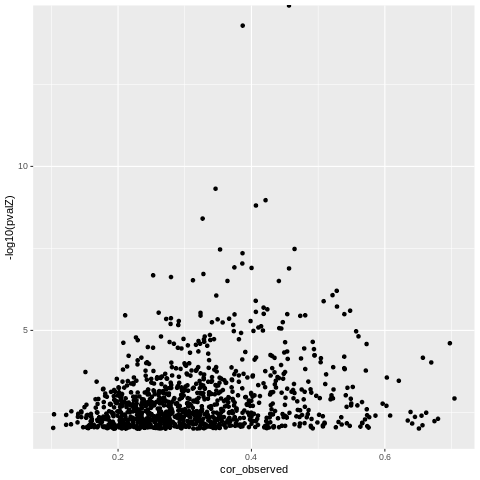

In [113]:
%%R
library(ggplot2)
ggplot(signif_cor_observed, aes(cor_observed, -log10(pvalZ))) +
geom_point()

How can you assess that your predicted associations make sense? Some ideas:
- Use positive control: e.g. we expect that peaks in the proximity of Transcription Start Sites should be more frequently linked to gene expression.
- Can you define a set of "negative control pairs" where you _don't_ expect to see association?
- Are peaks associated to genes enriched in Transcription Factor motifs? Have a look at [muon helper functions](https://muon.readthedocs.io/en/latest/api/generated/muon.atac.tl.scan_sequences.html?highlight=motif) and [motifmatchr](http://bioconductor.org/packages/release/bioc/html/motifmatchr.html).

In [114]:
%%R -o signif_cor_observed
head(signif_cor_observed)

                    peak            gene cor_observed       pvalZ
1                   <NA>            <NA>           NA          NA
2                   <NA>            <NA>           NA          NA
3                   <NA>            <NA>           NA          NA
4 chr1-11051717-11052217 ENSG00000116649    0.2468047 0.001814225
5 chr1-11060551-11061051 ENSG00000116649    0.5429873 0.006828929
6 chr1-11061653-11062153 ENSG00000116649    0.2111255 0.004322403


In [117]:
signif_cor_observed = signif_cor_observed.dropna()

### Visualize pairs on embeddings

In [196]:
# [mdata["rna"].var_names[mdata["rna"].var["gene_id"] == x for x in signif_cor_observed.gene]
mdata["rna"].var["gene_id_clean"] = [x[0] for x in mdata["rna"].var["gene_id"].str.split('.')]
signif_cor_observed['gene_name'] = [mdata["rna"].var_names[mdata["rna"].var["gene_id_clean"] == x][0] for x in signif_cor_observed.gene]

In [204]:
mdata['atac'].var
mdata['atac'].var['peak_id'] = mdata['atac'].var.seqnames.astype('str') + "-" + mdata['atac'].var.start.astype('str') + "-" + mdata['atac'].var.end.astype('str')    

mdata['atac'].var_names = mdata['atac'].var["peak_id"]

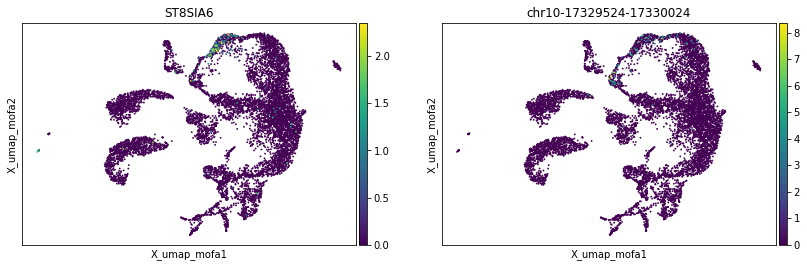

None


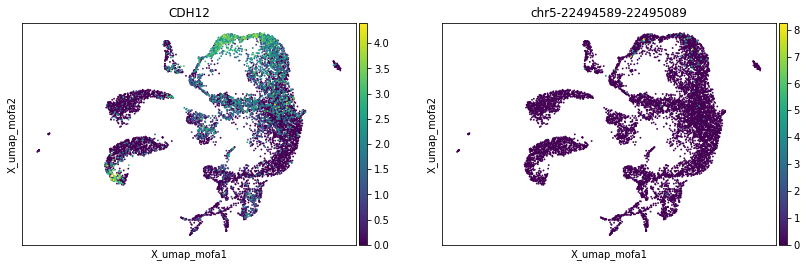

None


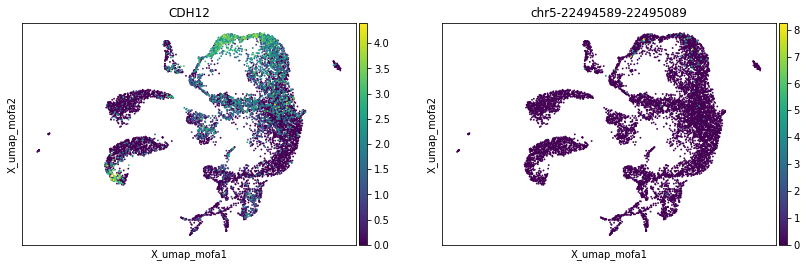

None


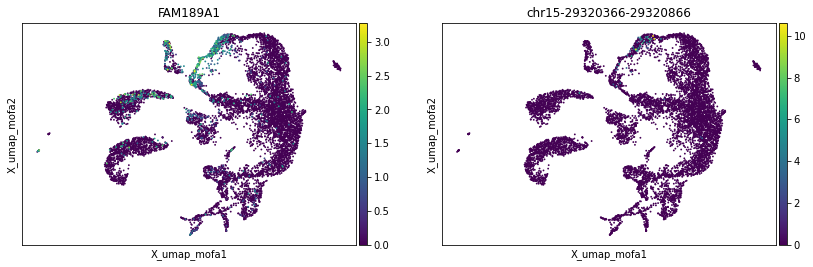

None


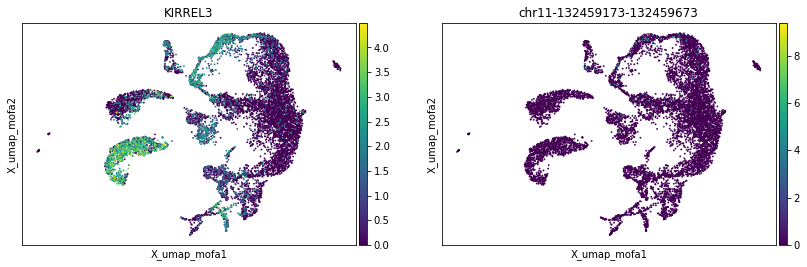

None


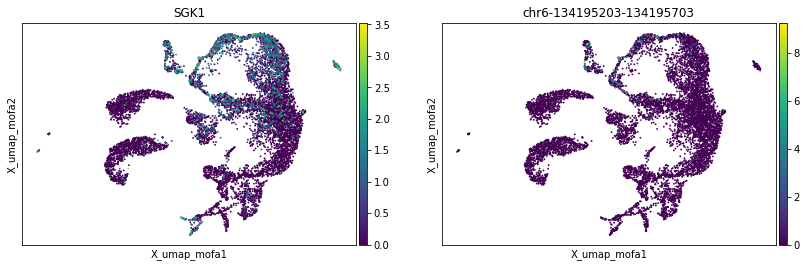

None


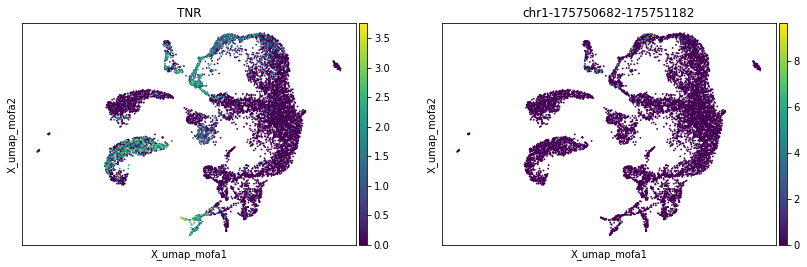

None


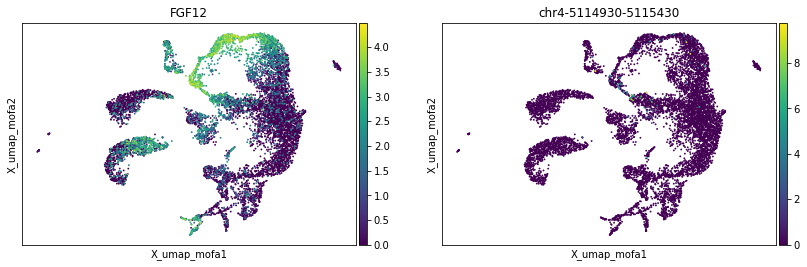

None


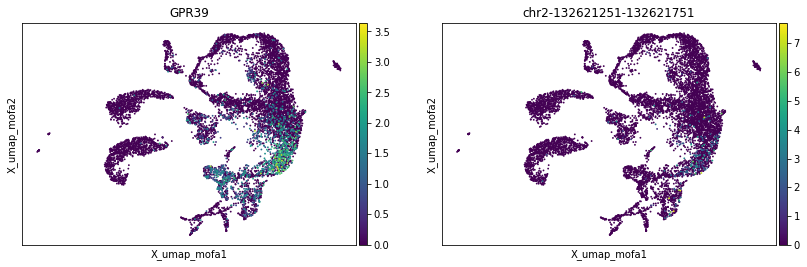

None


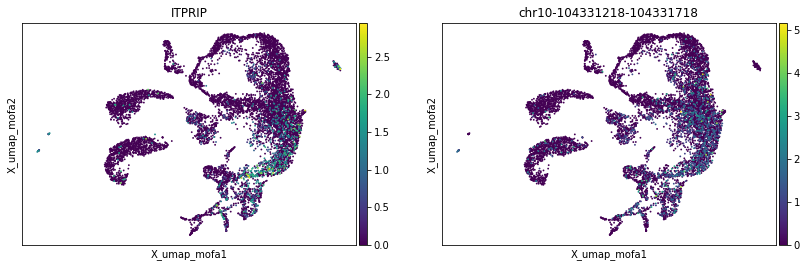

None


In [219]:
def plot_p2g_pair(mdata, g, p):
    mdata.obs['g_expression'] = mdata['rna'][:,g].X.toarray().ravel()
    mdata.obs['p_accessibility'] = mdata['atac'][:,p].X.toarray().ravel()
    sc.pl.embedding(mdata, "X_umap_mofa", color=['g_expression', 'p_accessibility'], title=(g,p))

smp_ixs = np.random.choice(signif_cor_observed[signif_cor_observed.cor_observed > 0.4].index, 10) 
for i in smp_ixs:
    print(plot_p2g_pair(mdata, signif_cor_observed['gene_name'][i], signif_cor_observed['peak'][i]))


### Distance to TSS

In [159]:
%%R -i signif_cor_observed
transcript_coords <- ensembldb::transcripts(EnsDb.Hsapiens.v86, filter = ~ gene_biotype == "protein_coding")
seqlevelsStyle(transcript_coords) <- 'UCSC'
transcript_coords <- keepStandardChromosomes(transcript_coords, pruning.mode = 'coarse')
tss_coords <- resize(unlist(range(split(transcript_coords, ~ tx_id))), width=1)

signif_peaks_gr <- StringToGRanges(signif_cor_observed[,'peak'], sep=c("-",'-'))
tss_distance <- distanceToNearest(signif_peaks_gr, tss_coords)
signif_cor_observed$tss_distance_signif <- tss_distance@elementMetadata$distance

In [160]:
%%R -o signif_cor_observed
nonsignif_peaks_gr <- StringToGRanges(sample(pairnames[,'peak'], length(signif_peaks_gr)), sep=c("-",'-'))
tss_distance <- distanceToNearest(nonsignif_peaks_gr, tss_coords)
signif_cor_observed$tss_distance_rand <- tss_distance@elementMetadata$distance

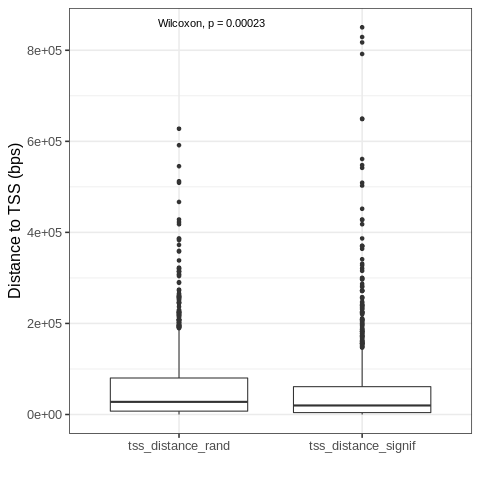

In [164]:
%%R
signif_cor_observed %>%
    pivot_longer(c("tss_distance_signif", "tss_distance_rand")) %>%
    ggplot(aes(name, value)) +
    geom_boxplot() +
    ggpubr::stat_compare_means() +
    theme_bw(base_size=16) +
    ylab("Distance to TSS (bps)") + xlab("")

---